<a href="https://colab.research.google.com/github/anshulk-cmu/CUDA_FFT_Implementation/blob/main/CUDA_FFT_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
/content/drive/MyDrive/cuda-fft/data
Generating test signals...


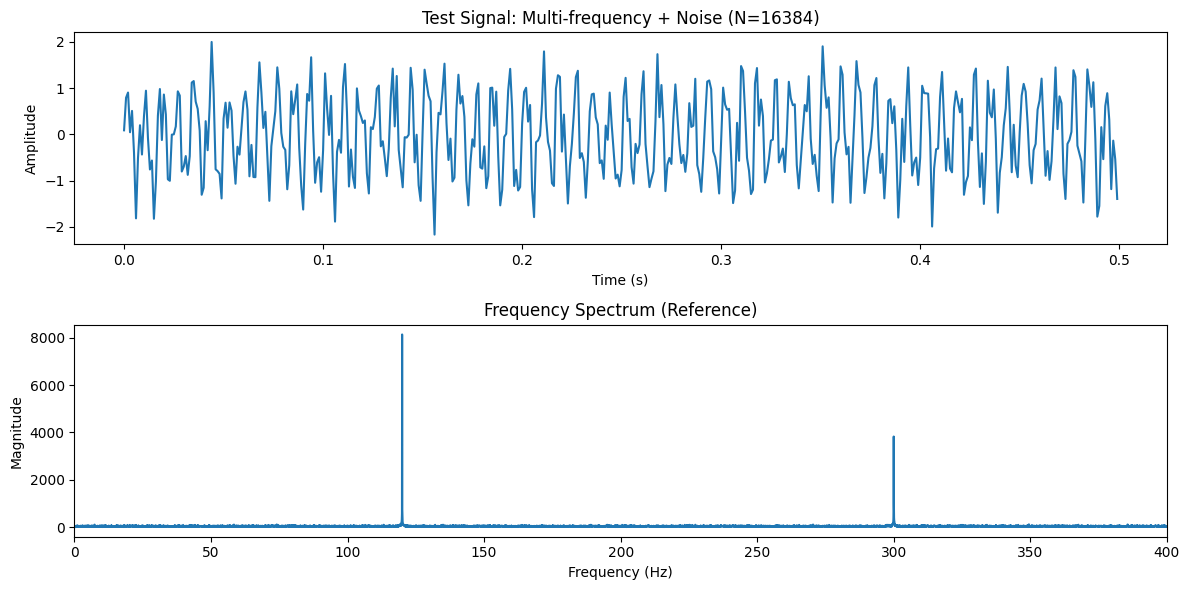


Generated test signals for sizes: [64, 256, 1024, 4096, 16384]
Total files created: 30 (.npy files)
Data types: float64 inputs, complex128 reference outputs


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir -p /content/drive/MyDrive/cuda-fft/data
!mkdir -p /content/drive/MyDrive/cuda-fft/prep
!mkdir -p /content/drive/MyDrive/cuda-fft/bin
%cd /content/drive/MyDrive/cuda-fft/data

# Generate test signals for FFT validation
import numpy as np
import matplotlib.pyplot as plt
import json

# Test signal parameters
sizes = [64, 256, 1024, 4096, 16384]  # Powers of 2 for FFT
fs = 1000.0  # Sampling frequency (Hz)

print("Generating test signals...")

for N in sizes:
    t = np.arange(N) / fs  # Time vector

    # Signal 1: Pure sine wave (single frequency)
    f1 = 50.0  # 50 Hz
    signal1 = np.sin(2 * np.pi * f1 * t)

    # Signal 2: Multi-frequency signal
    f2, f3 = 120.0, 300.0
    signal2 = (np.sin(2 * np.pi * f2 * t) +
               0.5 * np.sin(2 * np.pi * f3 * t) +
               0.3 * np.random.randn(N))  # Add noise

    # Signal 3: Chirp signal (frequency sweep)
    t_end = t[-1]
    signal3 = np.sin(2 * np.pi * (50 + 200 * t / t_end) * t)

    # Save signals (real parts only for now)
    np.save(f"signal_sine_{N}.npy", signal1.astype(np.float64))
    np.save(f"signal_multi_{N}.npy", signal2.astype(np.float64))
    np.save(f"signal_chirp_{N}.npy", signal3.astype(np.float64))

    # Generate reference FFT using NumPy (ground truth)
    fft_ref1 = np.fft.fft(signal1)
    fft_ref2 = np.fft.fft(signal2)
    fft_ref3 = np.fft.fft(signal3)

    # Save complex FFT results (real and imaginary parts)
    np.save(f"fft_ref_sine_{N}.npy", fft_ref1.astype(np.complex128))
    np.save(f"fft_ref_multi_{N}.npy", fft_ref2.astype(np.complex128))
    np.save(f"fft_ref_chirp_{N}.npy", fft_ref3.astype(np.complex128))

# Create metadata file
metadata = {
    "description": "FFT test signals and reference outputs",
    "sizes": sizes,
    "sampling_freq": fs,
    "signals": {
        "sine": "50 Hz pure sine wave",
        "multi": "120 Hz + 300 Hz + noise",
        "chirp": "50-250 Hz frequency sweep"
    },
    "data_types": {
        "input": "float64 (real)",
        "output": "complex128 (complex)"
    }
}

with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

# Quick visualization of largest signal
N = sizes[-1]
signal_test = np.load(f"signal_multi_{N}.npy")
t_test = np.arange(N) / fs

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_test[:500], signal_test[:500])  # First 500 samples
plt.title(f"Test Signal: Multi-frequency + Noise (N={N})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Show frequency spectrum
fft_test = np.load(f"fft_ref_multi_{N}.npy")
freqs = np.fft.fftfreq(N, 1/fs)
plt.subplot(2, 1, 2)
plt.plot(freqs[:N//2], np.abs(fft_test[:N//2]))
plt.title("Frequency Spectrum (Reference)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 400)

plt.tight_layout()
plt.savefig("test_signal_preview.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGenerated test signals for sizes: {sizes}")
print(f"Total files created: {len(sizes) * 6} (.npy files)")
print("Data types: float64 inputs, complex128 reference outputs")

In [6]:
# CPU FFT implementations (naive DFT + recursive FFT)
import numpy as np
import time
import json

def naive_dft(x):
    """O(N^2) naive DFT implementation for comparison"""
    N = len(x)
    X = np.zeros(N, dtype=np.complex128)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

def recursive_fft(x):
    """O(N log N) recursive FFT (Cooley-Tukey)"""
    N = len(x)
    if N <= 1:
        return x
    if N % 2 != 0:
        raise ValueError("Size must be power of 2")

    # Divide: separate even and odd indices
    even = recursive_fft(x[0::2])
    odd = recursive_fft(x[1::2])

    # Conquer: combine with twiddle factors
    X = np.zeros(N, dtype=np.complex128)
    for k in range(N // 2):
        w = np.exp(-2j * np.pi * k / N)  # Twiddle factor
        X[k] = even[k] + w * odd[k]
        X[k + N // 2] = even[k] - w * odd[k]

    return X

# Test different implementations on various sizes
sizes_test = [64, 256, 1024, 4096]  # Skip 16384 for naive DFT (too slow)
results = []

print("CPU FFT Performance Comparison")
print("=" * 60)
print(f"{'Size':<8} | {'Naive (ms)':<12} | {'Recursive (ms)':<15} | {'NumPy (ms)':<12} | {'Speedup':<8}")
print("-" * 60)

for N in sizes_test:
    # Load test signal
    signal = np.load(f"/content/drive/MyDrive/cuda-fft/data/signal_multi_{N}.npy")
    signal_complex = signal.astype(np.complex128)

    # 1) Naive DFT (only for smaller sizes)
    if N <= 1024:
        t0 = time.time()
        dft_result = naive_dft(signal_complex)
        t_naive = (time.time() - t0) * 1000
    else:
        t_naive = float('inf')  # Too slow
        dft_result = None

    # 2) Recursive FFT
    t0 = time.time()
    fft_result = recursive_fft(signal_complex)
    t_recursive = (time.time() - t0) * 1000

    # 3) NumPy FFT (optimized baseline)
    t0 = time.time()
    numpy_result = np.fft.fft(signal_complex)
    t_numpy = (time.time() - t0) * 1000

    # Verify correctness
    if dft_result is not None:
        error_naive = np.max(np.abs(dft_result - numpy_result))
        assert error_naive < 1e-9, f"Naive DFT error too large: {error_naive}"

    error_recursive = np.max(np.abs(fft_result - numpy_result))
    assert error_recursive < 1e-10, f"Recursive FFT error too large: {error_recursive}"

    # Calculate speedup
    speedup = t_recursive / t_numpy if t_numpy > 0 else 0

    # Display results
    naive_str = f"{t_naive:.3f}" if t_naive != float('inf') else "TOO_SLOW"
    print(f"{N:<8} | {naive_str:<12} | {t_recursive:<15.3f} | {t_numpy:<12.3f} | {speedup:<8.2f}x")

    results.append({
        "size": N,
        "naive_ms": t_naive if t_naive != float('inf') else None,
        "recursive_ms": t_recursive,
        "numpy_ms": t_numpy,
        "recursive_speedup": speedup
    })

# Test largest size with NumPy only
N_large = 16384
signal_large = np.load(f"/content/drive/MyDrive/cuda-fft/data/signal_multi_{N_large}.npy")
t0 = time.time()
numpy_large = np.fft.fft(signal_large.astype(np.complex128))
t_numpy_large = (time.time() - t0) * 1000

print(f"{N_large:<8} | {'SKIP':<12} | {'SKIP':<15} | {t_numpy_large:<12.3f} | {'REF':<8}")

results.append({
    "size": N_large,
    "naive_ms": None,
    "recursive_ms": None,
    "numpy_ms": t_numpy_large,
    "recursive_speedup": None
})

# Save timing results
with open("/content/drive/MyDrive/cuda-fft/prep/cpu_timings.json", "w") as f:
    json.dump(results, f, indent=2)

print("\nComplexity Analysis:")
print(f"• Naive DFT:     O(N²) - {1024**2:,} ops for N=1024")
print(f"• Recursive FFT: O(N log N) - {1024 * int(np.log2(1024)):,} ops for N=1024")
print(f"• Theoretical speedup: {1024**2 / (1024 * int(np.log2(1024))):.1f}x")
print(f"• Measured speedup (1024): {results[2]['naive_ms'] / results[2]['recursive_ms']:.1f}x")

CPU FFT Performance Comparison
Size     | Naive (ms)   | Recursive (ms)  | NumPy (ms)   | Speedup 
------------------------------------------------------------
64       | 6.107        | 0.443           | 0.056        | 7.91    x
256      | 96.154       | 2.188           | 0.071        | 30.90   x
1024     | 1614.782     | 10.430          | 0.081        | 129.43  x
4096     | TOO_SLOW     | 50.100          | 0.115        | 435.96  x
16384    | SKIP         | SKIP            | 0.533        | REF     

Complexity Analysis:
• Naive DFT:     O(N²) - 1,048,576 ops for N=1024
• Recursive FFT: O(N log N) - 10,240 ops for N=1024
• Theoretical speedup: 102.4x
• Measured speedup (1024): 154.8x


In [7]:
# Prepare FFT data for CUDA (bit-reversal + twiddle factors)
import numpy as np
import os
import json

def bit_reverse_index(n, bits):
    """Generate bit-reversed index for FFT input ordering"""
    result = 0
    for i in range(bits):
        if n & (1 << i):
            result |= (1 << (bits - 1 - i))
    return result

def generate_bit_reversal_table(N):
    """Create lookup table for bit-reversed indices"""
    bits = int(np.log2(N))
    table = np.zeros(N, dtype=np.int32)
    for i in range(N):
        table[i] = bit_reverse_index(i, bits)
    return table

def precompute_twiddle_factors(N):
    """Precompute all twiddle factors W_N^k = e^(-2πik/N)"""
    twiddles = np.zeros(N // 2, dtype=np.complex128)
    for k in range(N // 2):
        twiddles[k] = np.exp(-2j * np.pi * k / N)
    return twiddles

# Process each test size
sizes = [64, 256, 1024, 4096, 16384]
outdir = "/content/drive/MyDrive/cuda-fft/bin"
os.makedirs(outdir, exist_ok=True)

print("Preprocessing FFT data for CUDA...")
print("=" * 50)

for N in sizes:
    print(f"Processing size N={N}...")

    # 1) Load test signal and convert to complex
    signal_real = np.load(f"/content/drive/MyDrive/cuda-fft/data/signal_multi_{N}.npy")
    signal_complex = signal_real.astype(np.complex128)

    # 2) Separate real and imaginary parts for CUDA
    x_real = np.real(signal_complex).astype(np.float64)
    x_imag = np.imag(signal_complex).astype(np.float64)  # Will be zeros for real input

    # 3) Generate bit-reversal table
    bit_rev_table = generate_bit_reversal_table(N)

    # 4) Precompute twiddle factors
    twiddles = precompute_twiddle_factors(N)
    twiddle_real = np.real(twiddles).astype(np.float64)
    twiddle_imag = np.imag(twiddles).astype(np.float64)

    # 5) Load reference FFT for validation
    fft_ref = np.load(f"/content/drive/MyDrive/cuda-fft/data/fft_ref_multi_{N}.npy")
    ref_real = np.real(fft_ref).astype(np.float64)
    ref_imag = np.imag(fft_ref).astype(np.float64)

    # 6) Save binary files for CUDA
    prefix = f"{outdir}/fft_{N}"
    x_real.tofile(f"{prefix}_input_real.bin")
    x_imag.tofile(f"{prefix}_input_imag.bin")
    bit_rev_table.tofile(f"{prefix}_bitrev.bin")
    twiddle_real.tofile(f"{prefix}_twiddle_real.bin")
    twiddle_imag.tofile(f"{prefix}_twiddle_imag.bin")
    ref_real.tofile(f"{prefix}_ref_real.bin")
    ref_imag.tofile(f"{prefix}_ref_imag.bin")

    # 7) Create metadata for this size
    meta = {
        "N": int(N),
        "log2_N": int(np.log2(N)),
        "twiddle_count": int(N // 2),
        "input_dtype": "float64",
        "files": {
            "input_real": f"fft_{N}_input_real.bin",
            "input_imag": f"fft_{N}_input_imag.bin",
            "bit_reversal": f"fft_{N}_bitrev.bin",
            "twiddle_real": f"fft_{N}_twiddle_real.bin",
            "twiddle_imag": f"fft_{N}_twiddle_imag.bin",
            "reference_real": f"fft_{N}_ref_real.bin",
            "reference_imag": f"fft_{N}_ref_imag.bin"
        }
    }

    with open(f"{prefix}_meta.json", "w") as f:
        json.dump(meta, f, indent=2)

# Verify bit-reversal for small example
N_test = 8
print(f"\nBit-reversal verification (N={N_test}):")
bit_rev_test = generate_bit_reversal_table(N_test)
for i in range(N_test):
    print(f"  {i:03b} ({i}) → {bit_rev_test[i]:03b} ({bit_rev_test[i]})")

# Show twiddle factor pattern
N_test = 8
twiddles_test = precompute_twiddle_factors(N_test)
print(f"\nTwiddle factors (N={N_test}):")
for k in range(N_test // 2):
    w = twiddles_test[k]
    print(f"  W_{N_test}^{k} = {w.real:6.3f} + {w.imag:6.3f}j")

print(f"\nSaved binary data for sizes: {sizes}")
print(f"Files per size: 7 (.bin files + .json metadata)")
print(f"Total binary files: {len(sizes) * 7}")

# Quick size analysis
total_mb = 0
for N in sizes:
    # Each size has: 2 input arrays + 1 bitrev + 2 twiddle + 2 ref = 7 arrays
    # Sizes: N + N + N + N/2 + N/2 + N + N = 6N doubles + N int32s
    size_mb = (6 * N * 8 + N * 4) / (1024 * 1024)  # 8 bytes/double, 4 bytes/int
    total_mb += size_mb
    print(f"  N={N}: {size_mb:.2f} MB")

print(f"Total data size: {total_mb:.1f} MB")

Preprocessing FFT data for CUDA...
Processing size N=64...
Processing size N=256...
Processing size N=1024...
Processing size N=4096...
Processing size N=16384...

Bit-reversal verification (N=8):
  000 (0) → 000 (0)
  001 (1) → 100 (4)
  010 (2) → 010 (2)
  011 (3) → 110 (6)
  100 (4) → 001 (1)
  101 (5) → 101 (5)
  110 (6) → 011 (3)
  111 (7) → 111 (7)

Twiddle factors (N=8):
  W_8^0 =  1.000 +  0.000j
  W_8^1 =  0.707 + -0.707j
  W_8^2 =  0.000 + -1.000j
  W_8^3 = -0.707 + -0.707j

Saved binary data for sizes: [64, 256, 1024, 4096, 16384]
Files per size: 7 (.bin files + .json metadata)
Total binary files: 35
  N=64: 0.00 MB
  N=256: 0.01 MB
  N=1024: 0.05 MB
  N=4096: 0.20 MB
  N=16384: 0.81 MB
Total data size: 1.1 MB


In [8]:
%%writefile /content/fft_cuda.cu
#include <cstdio>
#include <cstdlib>
#include <cstdint>
#include <vector>
#include <fstream>
#include <cmath>
#include <cuda_runtime.h>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/copy.h>

// Complex number structure for GPU
struct Complex {
    double real, imag;
    __host__ __device__ Complex(double r = 0.0, double i = 0.0) : real(r), imag(i) {}
    __host__ __device__ Complex operator+(const Complex& other) const {
        return Complex(real + other.real, imag + other.imag);
    }
    __host__ __device__ Complex operator-(const Complex& other) const {
        return Complex(real - other.real, imag - other.imag);
    }
    __host__ __device__ Complex operator*(const Complex& other) const {
        return Complex(real * other.real - imag * other.imag,
                      real * other.imag + imag * other.real);
    }
};

__global__ void bit_reverse_kernel(const double* __restrict__ input_real,
                                   const double* __restrict__ input_imag,
                                   const int32_t* __restrict__ bit_rev_table,
                                   double* __restrict__ output_real,
                                   double* __restrict__ output_imag,
                                   int N) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < N) {
        int rev_idx = bit_rev_table[idx];
        output_real[idx] = input_real[rev_idx];
        output_imag[idx] = input_imag[rev_idx];
    }
}

__global__ void fft_butterfly_kernel(double* __restrict__ data_real,
                                     double* __restrict__ data_imag,
                                     const double* __restrict__ twiddle_real,
                                     const double* __restrict__ twiddle_imag,
                                     int N, int stage) {
    extern __shared__ double shared_mem[];
    double* s_real = shared_mem;
    double* s_imag = &shared_mem[blockDim.x];

    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // Load data into shared memory
    if (idx < N) {
        s_real[threadIdx.x] = data_real[idx];
        s_imag[threadIdx.x] = data_imag[idx];
    } else {
        s_real[threadIdx.x] = 0.0;
        s_imag[threadIdx.x] = 0.0;
    }
    __syncthreads();

    if (idx >= N) return;

    int step = 1 << stage;          // 2^stage
    int half_step = step >> 1;      // 2^(stage-1)
    int pos_in_group = idx % step;  // Position within group

    if (pos_in_group < half_step) {
        // This thread handles the butterfly operation
        int partner = idx + half_step;
        if (partner < N) {
            // Load twiddle factor
            int twiddle_idx = pos_in_group * (N / step);
            double wr = twiddle_real[twiddle_idx];
            double wi = twiddle_imag[twiddle_idx];

            // Load butterfly inputs
            double ar = s_real[threadIdx.x];
            double ai = s_imag[threadIdx.x];
            double br, bi;

            if (partner < blockIdx.x * blockDim.x + blockDim.x) {
                // Partner is in same block
                int partner_local = partner - blockIdx.x * blockDim.x;
                br = s_real[partner_local];
                bi = s_imag[partner_local];
            } else {
                // Partner is in different block, load from global memory
                br = data_real[partner];
                bi = data_imag[partner];
            }

            // Butterfly computation: w * b
            double temp_r = wr * br - wi * bi;
            double temp_i = wr * bi + wi * br;

            // Butterfly outputs
            double out1_r = ar + temp_r;
            double out1_i = ai + temp_i;
            double out2_r = ar - temp_r;
            double out2_i = ai - temp_i;

            // Store results
            s_real[threadIdx.x] = out1_r;
            s_imag[threadIdx.x] = out1_i;

            if (partner < blockIdx.x * blockDim.x + blockDim.x) {
                int partner_local = partner - blockIdx.x * blockDim.x;
                s_real[partner_local] = out2_r;
                s_imag[partner_local] = out2_i;
            }
        }
    }

    __syncthreads();

    // Write back to global memory
    if (idx < N) {
        data_real[idx] = s_real[threadIdx.x];
        data_imag[idx] = s_imag[threadIdx.x];
    }
}

static void read_bin(const char* path, void* buf, size_t bytes) {
    std::ifstream f(path, std::ios::binary);
    if (!f) { fprintf(stderr, "Cannot open %s\n", path); std::exit(1); }
    f.read(reinterpret_cast<char*>(buf), bytes);
    if (!f) { fprintf(stderr, "Short read on %s\n", path); std::exit(1); }
}

double compute_error(const std::vector<double>& result_real,
                    const std::vector<double>& result_imag,
                    const std::vector<double>& ref_real,
                    const std::vector<double>& ref_imag) {
    double max_error = 0.0;
    for (size_t i = 0; i < result_real.size(); ++i) {
        double err_r = std::abs(result_real[i] - ref_real[i]);
        double err_i = std::abs(result_imag[i] - ref_imag[i]);
        double err = std::sqrt(err_r * err_r + err_i * err_i);
        max_error = std::max(max_error, err);
    }
    return max_error;
}

int main() {
    printf("=== CUDA FFT Implementation ===\n");

    std::vector<int> sizes = {64, 256, 1024, 4096, 16384};

    for (int N : sizes) {
        printf("\n==================================================\n");
        printf("Processing FFT size N = %d\n", N);
        printf("Stages required: %d\n", int(log2(N)));

        int log2_N = int(log2(N));

        // Load data from binary files
        printf("Loading data from disk...\n");
        cudaEvent_t load_start, load_end;
        cudaEventCreate(&load_start); cudaEventCreate(&load_end);
        cudaEventRecord(load_start);

        std::vector<double> h_input_real(N), h_input_imag(N);
        std::vector<int32_t> h_bit_rev(N);
        std::vector<double> h_twiddle_real(N/2), h_twiddle_imag(N/2);
        std::vector<double> h_ref_real(N), h_ref_imag(N);

        char path[256];
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_input_real.bin", N);
        read_bin(path, h_input_real.data(), N * sizeof(double));
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_input_imag.bin", N);
        read_bin(path, h_input_imag.data(), N * sizeof(double));
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_bitrev.bin", N);
        read_bin(path, h_bit_rev.data(), N * sizeof(int32_t));
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_twiddle_real.bin", N);
        read_bin(path, h_twiddle_real.data(), (N/2) * sizeof(double));
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_twiddle_imag.bin", N);
        read_bin(path, h_twiddle_imag.data(), (N/2) * sizeof(double));
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_ref_real.bin", N);
        read_bin(path, h_ref_real.data(), N * sizeof(double));
        sprintf(path, "/content/drive/MyDrive/cuda-fft/bin/fft_%d_ref_imag.bin", N);
        read_bin(path, h_ref_imag.data(), N * sizeof(double));

        // Transfer to GPU
        printf("Transferring to GPU...\n");
        thrust::device_vector<double> d_input_real = h_input_real;
        thrust::device_vector<double> d_input_imag = h_input_imag;
        thrust::device_vector<int32_t> d_bit_rev = h_bit_rev;
        thrust::device_vector<double> d_twiddle_real = h_twiddle_real;
        thrust::device_vector<double> d_twiddle_imag = h_twiddle_imag;
        thrust::device_vector<double> d_data_real(N), d_data_imag(N);

        cudaEventRecord(load_end);
        cudaEventSynchronize(load_end);
        float load_ms;
        cudaEventElapsedTime(&load_ms, load_start, load_end);

        double total_mb = (6.0 * N * sizeof(double) + N * sizeof(int32_t)) / (1024.0 * 1024.0);
        printf("Memory transfer: %.1f ms (%.1f MB)\n", load_ms, total_mb);

        // GPU configuration
        const int threads = 256;
        const int blocks = (N + threads - 1) / threads;
        const size_t shared_mem_size = 2 * threads * sizeof(double);

        printf("GPU Configuration:\n");
        printf("  Threads per block: %d\n", threads);
        printf("  Blocks: %d\n", blocks);
        printf("  Shared memory: %.1f KB per block\n", shared_mem_size / 1024.0);

        // Start FFT computation timing
        cudaEvent_t compute_start, compute_end;
        cudaEventCreate(&compute_start); cudaEventCreate(&compute_end);
        cudaEventRecord(compute_start);

        printf("\nStarting FFT computation...\n");
        printf("Stage | Time (ms) | Status\n");
        printf("------|-----------|--------\n");

        // Step 1: Bit reversal
        cudaEvent_t stage_start, stage_end;
        cudaEventCreate(&stage_start); cudaEventCreate(&stage_end);
        cudaEventRecord(stage_start);

        bit_reverse_kernel<<<blocks, threads>>>(
            thrust::raw_pointer_cast(d_input_real.data()),
            thrust::raw_pointer_cast(d_input_imag.data()),
            thrust::raw_pointer_cast(d_bit_rev.data()),
            thrust::raw_pointer_cast(d_data_real.data()),
            thrust::raw_pointer_cast(d_data_imag.data()),
            N);
        cudaDeviceSynchronize();

        cudaEventRecord(stage_end);
        cudaEventSynchronize(stage_end);
        float stage_ms;
        cudaEventElapsedTime(&stage_ms, stage_start, stage_end);
        printf(" BR   | %8.3f | Bit-reverse\n", stage_ms);

        // Step 2: FFT stages
        float total_fft_ms = 0.0;
        for (int stage = 1; stage <= log2_N; ++stage) {
            cudaEventRecord(stage_start);

            fft_butterfly_kernel<<<blocks, threads, shared_mem_size>>>(
                thrust::raw_pointer_cast(d_data_real.data()),
                thrust::raw_pointer_cast(d_data_imag.data()),
                thrust::raw_pointer_cast(d_twiddle_real.data()),
                thrust::raw_pointer_cast(d_twiddle_imag.data()),
                N, stage);
            cudaDeviceSynchronize();

            cudaEventRecord(stage_end);
            cudaEventSynchronize(stage_end);
            cudaEventElapsedTime(&stage_ms, stage_start, stage_end);
            total_fft_ms += stage_ms;

            printf(" %2d   | %8.3f | Butterfly\n", stage, stage_ms);
        }

        cudaEventRecord(compute_end);
        cudaEventSynchronize(compute_end);
        float total_compute_ms;
        cudaEventElapsedTime(&total_compute_ms, compute_start, compute_end);

        // Copy results back and verify
        std::vector<double> result_real(N), result_imag(N);
        thrust::copy(d_data_real.begin(), d_data_real.end(), result_real.begin());
        thrust::copy(d_data_imag.begin(), d_data_imag.end(), result_imag.begin());

        double max_error = compute_error(result_real, result_imag, h_ref_real, h_ref_imag);

        printf("\n=== Results Summary ===\n");
        printf("Total computation: %.3f ms\n", total_compute_ms);
        printf("Butterfly stages:  %.3f ms\n", total_fft_ms);
        printf("Bit reversal:      %.3f ms\n", total_compute_ms - total_fft_ms);
        printf("Maximum error:     %.2e\n", max_error);
        printf("Accuracy:          %s\n", (max_error < 1e-10) ? "PASS" : "FAIL");

        // Performance metrics
        double ops = N * log2_N * 5.0;  // ~5 ops per butterfly
        double gflops = ops / (total_compute_ms * 1e6);
        double bytes = 4.0 * N * sizeof(double) * log2_N;  // Rough estimate
        double bandwidth = bytes / (total_compute_ms * 1e6);

        printf("Performance:       %.2f GFLOPS\n", gflops);
        printf("Memory bandwidth:  %.2f GB/s\n", bandwidth);

        // JSON output
        printf("JSON_RESULT: {\"N\":%d,\"total_ms\":%.3f,\"fft_ms\":%.3f,\"error\":%.2e,"
               "\"gflops\":%.2f,\"bandwidth_GBps\":%.2f}\n",
               N, total_compute_ms, total_fft_ms, max_error, gflops, bandwidth);

        // Cleanup
        cudaEventDestroy(load_start); cudaEventDestroy(load_end);
        cudaEventDestroy(compute_start); cudaEventDestroy(compute_end);
        cudaEventDestroy(stage_start); cudaEventDestroy(stage_end);
    }

    printf("\n=== FFT Implementation Complete ===\n");
    return 0;
}

Overwriting /content/fft_cuda.cu


In [9]:
# Compile CUDA FFT with clean warnings
!nvcc -O3 -arch=sm_75 /content/fft_cuda.cu -o /content/fft_cuda

# Run the FFT implementation
!/content/fft_cuda

=== CUDA FFT Implementation ===

Processing FFT size N = 64
Stages required: 6
Loading data from disk...
Transferring to GPU...
Memory transfer: 16.2 ms (0.0 MB)
GPU Configuration:
  Threads per block: 256
  Blocks: 1
  Shared memory: 4.0 KB per block

Starting FFT computation...
Stage | Time (ms) | Status
------|-----------|--------
 BR   |    0.029 | Bit-reverse
  1   |    0.037 | Butterfly
  2   |    0.016 | Butterfly
  3   |    0.014 | Butterfly
  4   |    0.014 | Butterfly
  5   |    0.014 | Butterfly
  6   |    0.013 | Butterfly

=== Results Summary ===
Total computation: 0.253 ms
Butterfly stages:  0.109 ms
Bit reversal:      0.143 ms
Maximum error:     4.80e-15
Accuracy:          PASS
Performance:       0.01 GFLOPS
Memory bandwidth:  0.05 GB/s
JSON_RESULT: {"N":64,"total_ms":0.253,"fft_ms":0.109,"error":4.80e-15,"gflops":0.01,"bandwidth_GBps":0.05}

Processing FFT size N = 256
Stages required: 8
Loading data from disk...
Transferring to GPU...
Memory transfer: 11.8 ms (0.0 MB)
